# torch.nn은 무엇인가
- 앞서 파이썬만으로 아주 기초적인 네트워크를 구성 해보았다
- 이번엔 torch.nn의 다양한 함수를 사용해 더 보기편하게 만들것이다

In [1]:
# 데이터 다운로드 및 저장
from pathlib import Path
import requests

# data 폴더 경로를 가져온다
DATA_PATH = Path('data')
print(DATA_PATH)
# mnist를 넣을 폴더경로를 초기화한다
PATH = DATA_PATH / 'mnist'
print(PATH)
# mnist 폴더를 만든다
PATH.mkdir(parents=True, exist_ok=True)

# 링크 주소와 가져올 파일이름을 지정
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

# 해당파일이 없으면 request 하여 해당파일을 가져와 저장한다
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        # 파일을 바이너리쓰기 모드로 호출하여 다운받은 내용을 써준다
        (PATH / FILENAME).open("wb").write(content)
        


data
data\mnist


In [2]:
# 학습 데이터 초기화
import pickle
import gzip

# 압축된 gz파일을 열어 문자열형태로 전달한다
with gzip.open((PATH/FILENAME).as_posix(), "rb") as f:
    # 피클파일에서 학습데이터 초기화
    ((x_train, y_train), (x_valid,y_valid), _) = pickle.load(f,
    encoding='latin-1')

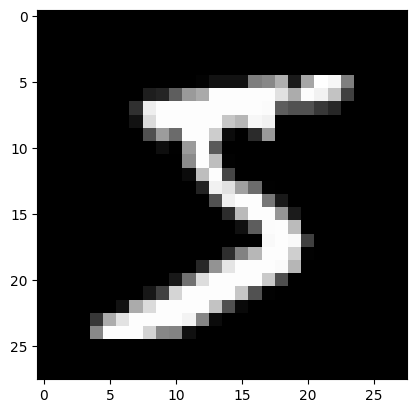

<class 'numpy.ndarray'>
(50000, 784)


In [3]:
# 데이터 이미지 확인
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
plt.show()

print(type(x_train)) # 넘파이배열이다
print(x_train.shape)  # 5만개, 784길이의 배열
# 이를 28,28형태로 바꾸어 이미지로 볼수있는것이다

In [4]:
# 넘파이 배열을 텐서로 변환
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train,y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train,y_train) #텐서확인
print(x_train.shape) # 텐서형태(사이즈) 확인
print(min(y_train), max(y_train))  # 타겟데이터 range 확인

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
# nn.Module을 사용하지않고 텐서로만 네트워크 기초 구성해보기
import math
# 가중치는 Xavier initialisation 으로 초기화한다
weights = torch.randn(784,10) / math.sqrt(784)
# 텐서의 그래이디언트 계산 여부를 설정  # 후행_은 원본텐서를 직접 변경하는것
# 이렇게하면 backward()할때 자동으로 미분계산됨(그래이디언트를 계산함) 
weights.requires_grad_()
print(weights)
# 10개의 편향 값을 0으로 생성해둠 , 자동미분도 활성
bias = torch.zeros(10,  requires_grad=True)


tensor([[ 0.0253,  0.0412, -0.0353,  ...,  0.0255,  0.0073, -0.0514],
        [ 0.0231,  0.0084, -0.0358,  ...,  0.0045,  0.0435, -0.0939],
        [-0.0516, -0.0895,  0.0209,  ...,  0.0170,  0.0257,  0.0389],
        ...,
        [ 0.0143,  0.0385, -0.0248,  ..., -0.0342,  0.0378, -0.0163],
        [ 0.0150, -0.0424,  0.0055,  ...,  0.0148, -0.0287,  0.0031],
        [-0.0101,  0.0228,  0.0106,  ...,  0.0551,  0.0267, -0.0670]],
       requires_grad=True)


In [6]:
# 하나의 배치만 예측해보기
bs = 64 
xb = x_train[0:bs]
# preds = model(xb)
# print(preds[0], preds.shape)

yb = y_train[0:bs]


In [7]:
# 예측이 정확한지 확인해보기
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

# print(accuracy(preds, yb))
# print(preds)
# torch.argmax(preds, dim=1)

# 활성화함수와 로스펑션을 합친다
import torch.nn.functional as F

# 크로스엔트로피에는 nll과 log softmax계산이 같이 포함되어 있다
loss_func = F.cross_entropy


In [8]:
# 모델을 재구성해본다
# nn.Module을 사용해 모델 구성해보기
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self,xb):
        return self.lin(xb)

# 클래스로 하기때문에 초기화를 이렇게 해준다 
model = Mnist_Logistic()

# 그러면 똑같이 결과를 볼수있다
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3072, grad_fn=<NllLossBackward0>) tensor(0.0781)


In [9]:
# dataloader 사용해보기
from torch.utils.data import DataLoader, TensorDataset

# 데이터셋을 만들고
train_ds = TensorDataset(x_train, y_train) 
#이제 이렇게 할수 있다
# xb, yb = train_ds[i*bs: i*bs+bs]

# 거기에 데이터 로더를 만들면 배치만큼 학습시키기 편해진다
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# 검증용도 따로 만든다
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [10]:
#학습코드를 간략화 할수있다 
from torch import optim
def loss_batch(model, loss_func, xb,yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() #학습모드
        # for i in range((n-1)// bs +1):
        #     xb, yb = train_ds[i*bs:i*bs+bs]
        for xb,yb in train_dl:
            # pred = model(xb)
            # loss = loss_func(pred, yb)
            # loss.backward()
            # opt.step()
            # opt.zero_grad()
            loss_batch(model, loss_func, xb,yb, opt)
            
        model.eval() #추론모드
        with torch.no_grad():
            # valid_loss = sum(loss_func(model(xb), yb)for xb,yb in valid_dl)
            losses, nums = zip( *[loss_batch(model,loss_func,xb,yb) for xb, yb in valid_dl])
        
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # print(epoch, valid_loss/len(valid_dl))
        print(epoch, val_loss)

epochs = 5   
opt = optim.SGD(model.parameters(), lr=0.5)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
print(loss_func(model(xb), yb))


c:\Users\82105\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 0.33549554142951965
1 0.2928572556257248
2 0.3020114561021328
3 0.26980730143785475
4 0.29807566084861753
tensor(0.1348, grad_fn=<NllLossBackward0>)


In [12]:
# 데이터로드를 만드는 함수를 만드어서 구성하면 더간단해짐
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2 ),
    )
    
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2776214311599731
1 0.3019499307751656
2 0.33764593900442125
3 0.2873711149454117
4 0.2933280053734779


In [14]:
# CNN 모델을 만드렁본다
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # reshape랑 같다
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

model = Mnist_CNN()
# momentum: 이전의 업데이트를 고려하는 확률적경사하강법의 편차
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  
fit(epochs, model, loss_func, opt, train_dl, valid_dl)  
        

0 0.31702889465093614
1 0.270516131901741
2 0.20579827901721
3 0.16876020707786082
4 0.16174777357876302


In [15]:
# sequential하게 만들어 본다
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28,28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4323969729423523
1 0.2120158810377121
2 0.17575165195763112
3 0.16344655957221985
4 0.17871132216453553
